In [18]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os

LSTM, short for Long Short-Term Memory, is a type of recurrent neural network (RNN) architecture that is commonly used for sequential data analysis and prediction. It is designed to address the vanishing gradient problem that occurs in traditional RNNs, which makes it difficult for the network to learn long-term dependencies.

LSTM networks consist of memory cells that can store information over long periods of time and are equipped with gating mechanisms to control the flow of information. These gates, including the input gate, forget gate, and output gate, enable the network to selectively remember or forget information as it processes sequences of data.

To use LSTM for forecasting resale ticket prices, you can follow these steps:

Data collection: Gather historical ticket prices along with relevant features such as event type, venue, date, seating section, and any other factors that may impact the ticket price.

Data preprocessing: Prepare the data for training by normalizing the numerical features, encoding categorical variables, and splitting the dataset into training and testing sets. It's important to maintain the temporal order of the data.

Feature selection: Identify the most relevant features for your forecasting task. This may involve analyzing correlations, conducting feature importance analysis, or using domain knowledge.

LSTM model design: Construct an LSTM network architecture suitable for your task. The architecture typically consists of an input layer, one or more LSTM layers, and an output layer. You can experiment with the number of LSTM layers, the number of memory cells, and the activation functions to find the optimal configuration.

Model training: Train the LSTM model using the training dataset. During training, the model learns to recognize patterns and dependencies in the historical ticket price data.

Model evaluation: Evaluate the trained model using the testing dataset to assess its performance. Common evaluation metrics for regression tasks include mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE).

Forecasting: Once the model is trained and evaluated, you can use it to make predictions on new, unseen data. Provide the relevant features for the desired ticket, and the model will generate a forecasted resale price.

In [56]:
# Load in csv
df = pd.read_csv('C:/Users/tmanett/Desktop/Manifest Optimization/TML Manifest Data.csv')
df.index = pd.to_datetime(df['event_date'])
df

C:\Users\tmanett\AppData\Local\Temp\ipykernel_11664\2113890217.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/tmanett/Desktop/Manifest Optimization/TML Manifest Data.csv')


,Unnamed: 0,event_date,event_name,section_name,row_name,seat_num,activity_name,fiscal,tier,def_price_code,...,section_index,row_index,team,price_code_desc,price_diff_perc,price_diff_doll,resale_price,face_value,resale_price_outlier,price_diff_perc_outlier
event_date,,,,,,,,,,,,,,,,,,,,,
2016-02-18,1,2/18/2016,L160218,101,15,17,TE Resale,F16,5,F,...,0.517241,0.500000,New York Rangers,Light Gold,-0.059406,-12.0,190.0,202,no,no
2016-02-18,2,2/18/2016,L160218,101,15,18,TE Resale,F16,5,F,...,0.517241,0.529412,New York Rangers,Light Gold,-0.059406,-12.0,190.0,202,no,no
2016-02-18,3,2/18/2016,L160218,101,9,1,TE Resale,F16,5,C,...,0.310345,0.032258,New York Rangers,Plat Ends,-0.087678,-18.5,192.5,211,no,no
2016-02-18,4,2/18/2016,L160218,101,9,2,TE Resale,F16,5,C,...,0.310345,0.064516,New York Rangers,Plat Ends,-0.087678,-18.5,192.5,211,no,no
2016-02-25,5,2/25/2016,L160225,101,27,13,TE Resale,F16,5,I,...,0.931034,0.481481,Carolina Hurricanes,Club Ends,0.235669,37.0,194.0,157,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,303978,4/2/2023,L230402,118M,24,25,TE Resale,F23,4,H,...,0.857143,1.000000,Detroit Red Wings,Club Sides,0.044369,13.0,306.0,293,no,no
2023-04-02,303979,4/2/2023,L230402,101,4,3,TE Resale,F23,4,C,...,0.137931,0.107143,Detroit Red Wings,Plat Ends,0.086957,30.0,375.0,345,no,no
2023-04-02,303980,4/2/2023,L230402,101,4,4,TE Resale,F23,4,C,...,0.137931,0.142857,Detroit Red Wings,Plat Ends,0.086957,30.0,375.0,345,no,no


<Axes: xlabel='event_date'>

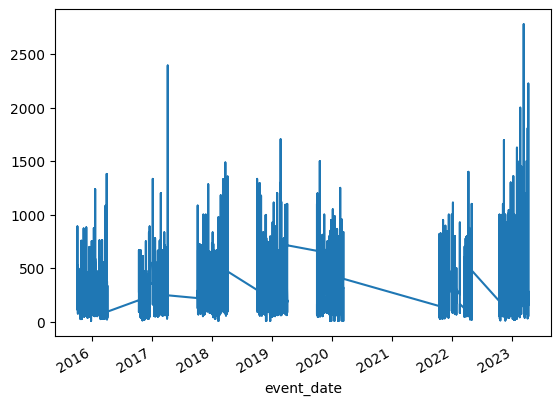

In [57]:
temp = df['resale_price']
temp.plot()

In [58]:
def df_to_X_y (df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i+window_size]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)

    return np.array(X), np.array(y)


In [59]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape, y.shape

((303977, 5, 1), (303977,))

In [70]:
total_samples = len(X)

train_size = int(0.6 * total_samples)
val_size = int(0.3 * total_samples)
test_size = total_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((182386, 5, 1), (182386,), (91193, 5, 1), (91193,), (30398, 5, 1), (30398,))

In [71]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [72]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [86]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
5700/5700 [==============================] - 42s 7ms/step - loss: 4314.6909 - root_mean_squared_error: 65.6863 - val_loss: 5413.0771 - val_root_mean_squared_error: 73.5736
Epoch 2/10
5694/5700 [============================>.] - ETA: 0s - loss: 4296.8569 - root_mean_squared_error: 65.5504

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


5700/5700 [==============================] - 44s 8ms/step - loss: 4296.3398 - root_mean_squared_error: 65.5465 - val_loss: 5328.0854 - val_root_mean_squared_error: 72.9937
Epoch 3/10
5700/5700 [==============================] - 40s 7ms/step - loss: 4283.3804 - root_mean_squared_error: 65.4475 - val_loss: 5392.4829 - val_root_mean_squared_error: 73.4335
Epoch 4/10
5698/5700 [============================>.] - ETA: 0s - loss: 4273.7690 - root_mean_squared_error: 65.3741

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


5700/5700 [==============================] - 45s 8ms/step - loss: 4273.3589 - root_mean_squared_error: 65.3709 - val_loss: 5321.2827 - val_root_mean_squared_error: 72.9471
Epoch 5/10
5700/5700 [==============================] - 40s 7ms/step - loss: 4276.3564 - root_mean_squared_error: 65.3939 - val_loss: 5351.9502 - val_root_mean_squared_error: 73.1570
Epoch 6/10
5694/5700 [============================>.] - ETA: 0s - loss: 4269.3901 - root_mean_squared_error: 65.3406

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


5700/5700 [==============================] - 45s 8ms/step - loss: 4267.3301 - root_mean_squared_error: 65.3248 - val_loss: 5288.5566 - val_root_mean_squared_error: 72.7225
Epoch 7/10
5693/5700 [============================>.] - ETA: 0s - loss: 4249.9819 - root_mean_squared_error: 65.1919

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


5700/5700 [==============================] - 48s 8ms/step - loss: 4250.0381 - root_mean_squared_error: 65.1923 - val_loss: 5269.3813 - val_root_mean_squared_error: 72.5905
Epoch 8/10
5700/5700 [==============================] - 42s 7ms/step - loss: 4257.8877 - root_mean_squared_error: 65.2525 - val_loss: 5336.3389 - val_root_mean_squared_error: 73.0502
Epoch 9/10
5694/5700 [============================>.] - ETA: 0s - loss: 4233.7109 - root_mean_squared_error: 65.0670

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


5700/5700 [==============================] - 47s 8ms/step - loss: 4246.4771 - root_mean_squared_error: 65.1650 - val_loss: 5234.7192 - val_root_mean_squared_error: 72.3514
Epoch 10/10
5700/5700 [==============================] - 42s 7ms/step - loss: 4239.0376 - root_mean_squared_error: 65.1079 - val_loss: 5363.1357 - val_root_mean_squared_error: 73.2334


In [74]:
# Calculate the minimum and maximum resale prices
min_price = np.min(df['resale_price'])
max_price = np.max(df['resale_price'])

# Print the range of resale prices
print("Minimum price:", min_price)
print("Maximum price:", max_price)

Minimum price: 5.0
Maximum price: 2780.0


In [87]:
from keras.models import load_model
model1 = load_model('model1/')

train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train})
train_results

5700/5700 [==============================] - 17s 3ms/step


,Train Predictions,Actuals
0,197.844284,194.0
1,196.561340,194.0
2,197.910782,194.0
3,197.589432,660.0
4,677.592773,660.0
...,...,...
182381,180.639343,117.0
182382,118.517761,117.0
182383,150.381668,230.0
182384,228.967926,230.0


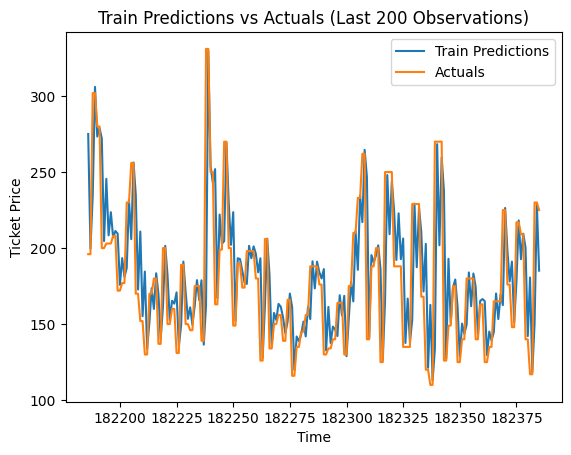

In [88]:
#plt.plot(train_results['Train Predictions'][:200])
#plt.plot(train_results['Actuals'][:200])

# Zooming in to the last 200 observations
last_200_train_results = train_results.tail(200)

# Plotting train predictions and actual values for the last 200 observations
plt.plot(last_200_train_results.index, last_200_train_results['Train Predictions'], label='Train Predictions')
plt.plot(last_200_train_results.index, last_200_train_results['Actuals'], label='Actuals')
plt.xlabel('Time')
plt.ylabel('Ticket Price')
plt.title('Train Predictions vs Actuals (Last 200 Observations)')
plt.legend()
plt.show()

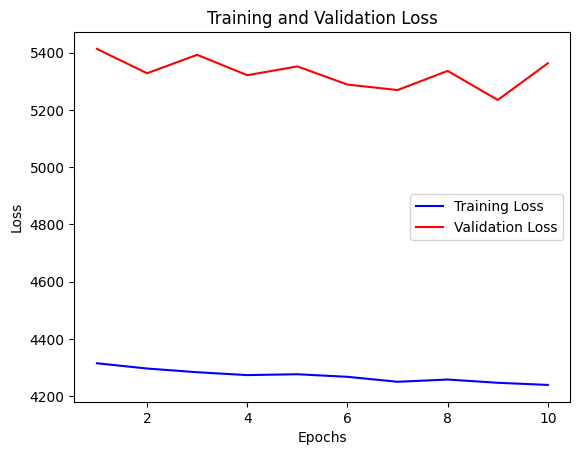

In [89]:
# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)

Training Loss: [4314.69091796875, 4296.33984375, 4283.38037109375, 4273.35888671875, 4276.3564453125, 4267.330078125, 4250.0380859375, 4257.8876953125, 4246.47705078125, 4239.03759765625]
Validation Loss: [5413.0771484375, 5328.08544921875, 5392.48291015625, 5321.28271484375, 5351.9501953125, 5288.556640625, 5269.38134765625, 5336.3388671875, 5234.71923828125, 5363.1357421875]
